In [ ]:
#Only run in colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/Taskmaster
#!pip install tensorflow --upgrade
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

In [7]:
import rubiks as rubiks
import numpy as np
from student import student
from classroom import classroom
from teacher import teacher
from rubiks_network_experimental import student_network
from utils import dotdict
from keras import regularizers
from custom_layers.unit_regularizer import UnitRegularizer

task = rubiks.rubiks_task
setup = rubiks.rubiks_setup
rng = np.random.default_rng(seed=0)

core_params = dotdict({
            "residual_weights_reg" : None,
            "residual_bias_reg" : None,
            "relu_leak" : 0.05,
            "residual_units" : 512,
            "residual_layers" : 1
})

value_network_params = dotdict({
            "residual_weights_reg" : None,
            "residual_bias_reg" : None,
            "relu_leak" : 0.05,
            "residual_units" : 512,
            "residual_filters" : 32,
            "learning_rate" : 3e-4,
            "residual_layers" : 2,
            "reward_fork_layers": 1,
            "value_fork_layers": 1
})

state_network_params = dotdict({
            "residual_weights_reg" : UnitRegularizer(1e-3,1e-3),
            "residual_bias_reg" : None,
            "relu_leak" : 0.05,
            "residual_units" : 512,
            "learning_rate" : 3e-4,
            "residual_layers" : 1
})

params = dotdict({
    "core_params":core_params,
    "value_network_params": value_network_params,
    "state_network_params": state_network_params,
    "task": task
})

my_student_network = student_network.create(params)
#my_student_network = student_network.load("models/combined/trained/trained")
student_template = student(task, 30,my_student_network,0.95)
t = teacher(setup, lambda n : 1+rng.poisson(lam=5,size=n))
c = classroom(task, setup, t, student_template, n_students=1, max_steps=10, buffer_size = lambda n : np.minimum(4096,np.maximum(1024,n//2)))

In [5]:
c.max_steps=10
c.buffer_size = lambda n : np.minimum(4096,np.maximum(1024,n//2))
t.step_dist = lambda n : 5*np.ones(n,dtype=int)

In [6]:

for i in range(50):
    print(f"Round {i}.")
    c.run_training_batch(n_problems=100,epochs_per_episode=3)
    #if i % 10 == 9:
    #    my_student_network.save("models/trained.h5")

Round 0.
Before step 1, 100 out of 100 remain open.
Before step 2, 96 out of 100 remain open.
Before step 3, 92 out of 100 remain open.
Before step 4, 71 out of 100 remain open.
Before step 5, 68 out of 100 remain open.
Before step 6, 57 out of 100 remain open.
Before step 7, 56 out of 100 remain open.
Before step 8, 53 out of 100 remain open.
Before step 9, 53 out of 100 remain open.
Before step 10, 53 out of 100 remain open.
After step 10, 53 out of 100 remain open.
Epoch 1/3
16/16 [==============================] - 3s 192ms/step - loss: 0.2476 - value_loss: 0.1846 - reward_loss: 0.0156 - confidence_loss: 0.0475
Epoch 2/3
16/16 [==============================] - 3s 193ms/step - loss: 0.1366 - value_loss: 0.0955 - reward_loss: 0.0114 - confidence_loss: 0.0297
Epoch 3/3
16/16 [==============================] - 3s 203ms/step - loss: 0.0901 - value_loss: 0.0565 - reward_loss: 0.0100 - confidence_loss: 0.0236
Round 1.
Before step 1, 100 out of 100 remain open.
Before step 2, 99 out of 100

KeyboardInterrupt: 

In [2]:
n=8192
rng = np.random.default_rng()
states = setup.initial_state.copy()[None,:].repeat(n,axis=0)

for k in range(50):
    print(f"Round {k}.")
    #c.run_training_batch(n_problems=100,epochs_per_episode=1)

    for i in range(100):
        _, states = rubiks.task_action(states,rng.choice(a=task.n_actions,size=n))

    actions = rng.choice(a=task.n_actions,size=n)
    _, next_states = rubiks.task_action(states,actions)

    actions = (np.arange(task.n_actions) == actions[...,None]).astype(float)
    colors = rubiks.make_neural_input(states)
    next_colors = rubiks.make_neural_input(next_states)
    my_student_network.fit_state(colors,actions,next_colors.reshape(n,54,6),epochs = 1)

    #if k % 10 == 9:
    #  my_student_network.save("models/combined/trained")

Round 0.


120/120 [==============================] - 18s 105ms/step - loss: 1.3379 - accuracy: 0.5309 - val_loss: 1.0144 - val_accuracy: 0.7212
Round 1.
  9/120 [=>............................] - ETA: 10s - loss: 1.0122 - accuracy: 0.7210

KeyboardInterrupt: 

In [5]:
my_student_network.state_network.optimizer.learning_rate = 1e-5

In [7]:
n=8192
rng = np.random.default_rng()
states = setup.initial_state.copy()[None,:].repeat(n,axis=0)

for i in range(50):
    _, states = rubiks.task_action(states,rng.choice(a=task.n_actions,size=n))

actions = rng.choice(a=task.n_actions,size=n)
_, next_states = rubiks.task_action(states,actions)

actions = (np.arange(task.n_actions) == actions[...,None]).astype(float)
colors = rubiks.make_neural_input(states)
next_colors = rubiks.make_neural_input(next_states)
results = my_student_network.predict_state(colors,actions).argmax(axis=-1)

same = np.all(next_colors.reshape(n,54,6).argmax(axis=-1) == results,axis=-1)
same.sum()/same.size

256/256 [==============================] - 5s 17ms/step


0.9989013671875

In [8]:
model=my_student_network.state_network
w=model.layers[3].weights[0].numpy()
v=w.copy()
np.count_nonzero(np.abs(w)<0.001)/w.size
#v[np.abs(w)<0.05]=0
#np.abs(v**2).mean(), np.abs(w**2).mean()
#print(w.max(axis=1))
#print(np.count_nonzero(w))

0.013744212962962963

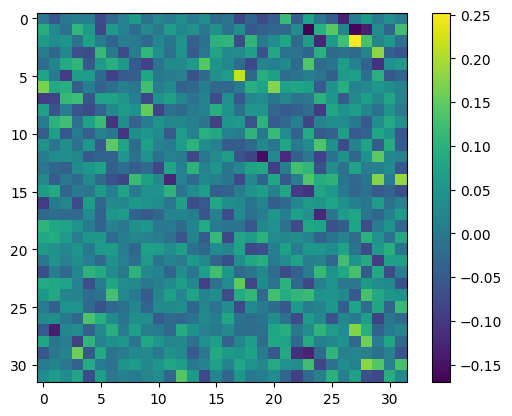

In [26]:
w=model.layers[3].weights[0].numpy()[0]
import matplotlib.pyplot as plt
im=plt.imshow(w[30].reshape(32,32))
plt.colorbar(im)

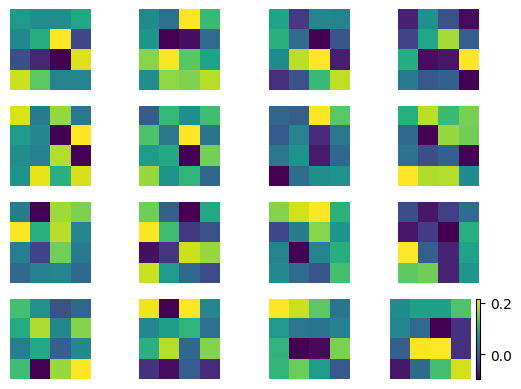

In [25]:
w=model.layers[10].weights[0].numpy()
fig, ax = plt.subplots(nrows=4,ncols=4)
for i in range(16):
    im = ax[i//4,i%4].imshow(w[:,:,i,0])
    ax[i//4,i%4].set_axis_off()

plt.colorbar(im)